<a href="https://colab.research.google.com/github/BuddhikaRoshan/HemoAi/blob/Sonali/IT22592088_CNN_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Paths and setup
import os, random, math, shutil, pathlib

DATASET_PATH = "/content/drive/MyDrive/Research/archive/cell_images/cell_images"  # <-- adjust if needed
WORK_DIR = "/content/malaria_subset_4k"
os.makedirs(WORK_DIR, exist_ok=True)

classes = ["Parasitized", "Uninfected"]

# 3. Create 2000-image subset (1000 per class)
files_by_class = {}
SAMPLES_PER_CLASS = 1000
for cls in classes:
    cls_dir = pathlib.Path(DATASET_PATH) / cls
    files = [str(p) for p in cls_dir.glob("*") if p.suffix.lower() in [".png", ".jpg", ".jpeg"]]
    random.shuffle(files)
    if len(files) < SAMPLES_PER_CLASS:
        raise ValueError(f"Not enough images in {cls}: found {len(files)}, need {SAMPLES_PER_CLASS}")
    files_by_class[cls] = files[:SAMPLES_PER_CLASS]

# Split 70/15/15
splits = {"train": 0.7, "val": 0.15, "test": 0.15}
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(WORK_DIR, split, cls), exist_ok=True)

for cls in classes:
    files = files_by_class[cls]
    n = len(files)
    n_train = math.floor(n * splits["train"])     # 1400 per class
    n_val   = math.floor(n * splits["val"])       # 300 per class
    train_files = files[:n_train]
    val_files   = files[n_train:n_train+n_val]
    test_files  = files[n_train+n_val:]

    for f in train_files:
        shutil.copy(f, os.path.join(WORK_DIR, "train", cls, os.path.basename(f)))
    for f in val_files:
        shutil.copy(f, os.path.join(WORK_DIR, "val", cls, os.path.basename(f)))
    for f in test_files:
        shutil.copy(f, os.path.join(WORK_DIR, "test", cls, os.path.basename(f)))

print("Subset created at:", WORK_DIR)


Mounted at /content/drive
Subset created at: /content/malaria_subset_4k


In [ ]:
# 5. CNN + ViT hybrid
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def transformer_block(x, num_heads, mlp_dim, dropout=0.1):
    # LayerNorm + MHA
    x_norm = layers.LayerNormalization(epsilon=1e-6)(x)
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1], dropout=dropout)(x_norm, x_norm)
    x = layers.Add()([x, attn])

    # LayerNorm + MLP
    x_norm = layers.LayerNormalization(epsilon=1e-6)(x)
    mlp = layers.Dense(mlp_dim, activation="gelu")(x_norm)
    mlp = layers.Dropout(dropout)(mlp)
    mlp = layers.Dense(x.shape[-1])(mlp)
    x = layers.Add()([x, mlp])
    return x

def build_cnn_vit(input_shape=(224, 224, 3),
                  cnn_channels=(32, 64, 128),
                  patch_size=16,
                  embed_dim=256,
                  num_transformer_blocks=4,
                  num_heads=8,
                  mlp_dim=512,
                  dropout=0.1):
    inputs = keras.Input(shape=input_shape)

    # CNN stem: downsample and enrich local features
    x = inputs
    for c in cnn_channels:
        x = layers.Conv2D(c, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(c, 3, padding="same", activation="relu")(x)
        x = layers.MaxPool2D()(x)  # reduces H,W

    # Ensure spatial dims divisible by patch_size
    # Resize feature map to a size divisible by patch_size (tokens grid)
    h, w = x.shape[1], x.shape[2]
    target_h = (h // patch_size) * patch_size
    target_w = (w // patch_size) * patch_size
    x = layers.Resizing(target_h, target_w, interpolation="bilinear")(x)

    # Linear projection of patches (Conv with stride=patch_size acts as patchify+proj)
    x = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(x)  # [B, H', W', D]
    h_tokens, w_tokens = x.shape[1], x.shape[2]
    num_tokens = h_tokens * w_tokens

    # Flatten to tokens
    x = layers.Reshape((num_tokens, embed_dim))(x)

    # Optional positional embedding
    pos_embed = layers.Embedding(input_dim=num_tokens, output_dim=embed_dim)
    positions = tf.range(start=0, limit=num_tokens, delta=1)
    x = x + pos_embed(positions)

    # Transformer encoder
    for _ in range(num_transformer_blocks):
        x = transformer_block(x, num_heads=num_heads, mlp_dim=mlp_dim, dropout=dropout)

    # Token pooling (mean pooling tends to be stable)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Classification head
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(mlp_dim, activation="gelu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="cnn_vit_hybrid")
    return model

model = build_cnn_vit(
    input_shape=(224, 224, 3),
    cnn_channels=(32, 64, 128),
    patch_size=16,        # tokens grid ~ 7x7 or 8x8 depending on stem
    embed_dim=256,
    num_transformer_blocks=4,
    num_heads=8,
    mlp_dim=512,
    dropout=0.1
)

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")]
)

model.summary()


Model: "cnn_vit_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 224, 224,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 224, 224,  │      9,248 │ conv2d_7[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 112, 112,  │     36,928 │ conv2d_9[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 56, 56,    │    147,584 │ conv2d_11[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 28, 28,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_1          │ (None, 16, 16,    │          0 │ max_pooling2d_5[… │
│ (Resizing)          │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 1, 1, 256) │  8,388,864 │ resizing_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 256)    │          0 │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 256)    │          0 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1, 256)    │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 256)    │  2,103,552 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 256)    │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 256)    │        512 │ add_1[0][0]     

 Total params: 18,278,433 (69.73 MB)

 Trainable params: 18,278,433 (69.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4. Data loading
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

train_ds = image_dataset_from_directory(
    os.path.join(WORK_DIR, "train"),
    labels="inferred",
    label_mode="binary",
    image_size=IMAGE_SIZE,
    interpolation="nearest",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    os.path.join(WORK_DIR, "val"),
    labels="inferred",
    label_mode="binary",
    image_size=IMAGE_SIZE,
    interpolation="nearest",
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = image_dataset_from_directory(
    os.path.join(WORK_DIR, "test"),
    labels="inferred",
    label_mode="binary",
    image_size=IMAGE_SIZE,
    interpolation="nearest",
    batch_size=BATCH_SIZE,
    shuffle=False
)


# 6. Train
callbacks = [
    keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor="val_acc"),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
]

history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)

# 7. Evaluation
test_metrics = model.evaluate(test_ds)
print("Test metrics:", dict(zip(model.metrics_names, test_metrics)))

import numpy as np
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred = np.concatenate([model.predict(x).ravel() for x, _ in test_ds], axis=0)
y_hat = (y_pred >= 0.5).astype(int)
acc = (y_hat == y_true).mean()
print(f"Thresholded test accuracy: {acc:.4f}")

# 8. Save (use Keras native format)
model.save("/content/malaria_model_cnn_vit.keras")


Found 1400 files belonging to 2 classes.
Found 300 files belonging to 2 classes.
Found 300 files belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


44/44 ━━━━━━━━━━━━━━━━━━━━ 603s 13s/step - acc: 0.4914 - auc: 0.4781 - loss: 0.8526 - val_acc: 0.5000 - val_auc: 0.5976 - val_loss: 0.7111 - learning_rate: 3.0000e-04
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 601s 13s/step - acc: 0.5152 - auc: 0.5197 - loss: 0.7124 - val_acc: 0.5000 - val_auc: 0.6647 - val_loss: 0.7130 - learning_rate: 3.0000e-04
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 626s 13s/step - acc: 0.5037 - auc: 0.5235 - loss: 0.7236 - val_acc: 0.5933 - val_auc: 0.6748 - val_loss: 0.6588 - learning_rate: 3.0000e-04
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 565s 13s/step - acc: 0.6730 - auc: 0.7439 - loss: 0.5921 - val_acc: 0.9300 - val_auc: 0.9668 - val_loss: 0.2339 - learning_rate: 3.0000e-04
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 583s 13s/step - acc: 0.9129 - auc: 0.9288 - loss: 0.2889 - val_acc: 0.9233 - val_auc: 0.9693 - val_loss: 0.2420 - learning_rate: 3.0000e-04
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 557s 13s/step - acc: 0.9271 - auc: 0.9593 - loss: 0.2292 - val_acc: 0.9300 - val_au

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Thresholded test accuracy: 0.5000



=== Classification Report ===
              precision    recall  f1-score   support

 Parasitized       0.95      0.92      0.94       150
  Uninfected       0.92      0.95      0.94       150

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



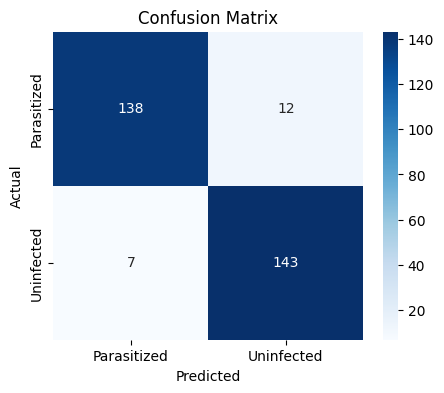

<Figure size 640x480 with 0 Axes>

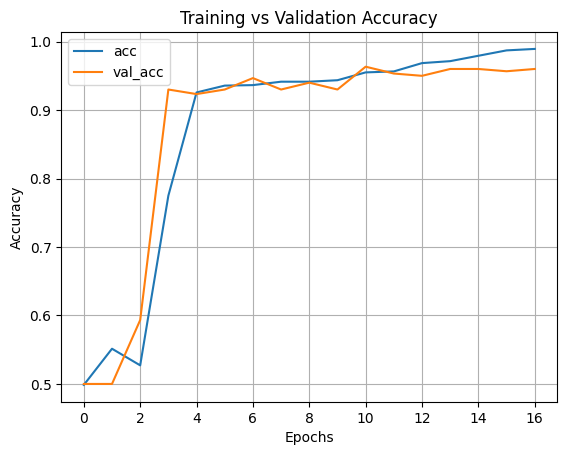

<Figure size 640x480 with 0 Axes>

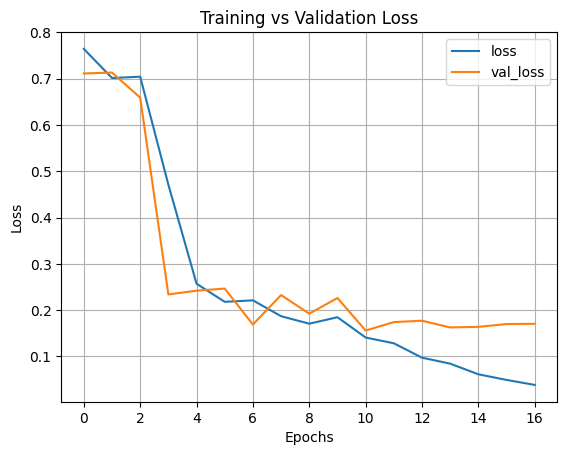

In [ ]:
# 9. Visualization (confusion matrix & curves)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print("\n=== Classification Report ===")
from sklearn.metrics import classification_report
print(classification_report(y_true, y_hat, target_names=classes))

cm = confusion_matrix(y_true, y_hat)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

history_df = pd.DataFrame(history.history)
plt.figure()
history_df[['acc', 'val_acc']].plot()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

plt.figure()
history_df[['loss', 'val_loss']].plot()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
import pickle

# ========================
# Save model & encoders
# ========================
model.save("cnn_vit_rbc_manualsplit.keras")

print("\n✅ Final model saved with manual RBC extraction and proper split")


✅ Final model saved with manual RBC extraction and proper split


In [ ]:
# ========================
# Save model & encoders
# ========================
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os

try:
    le
except NameError:
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)  # y = your target labels
    print("✅ LabelEncoder fitted")

# If 'scaler' doesn't exist, define and fit it
try:
    le
except NameError:
    # Define and fit LabelEncoder if it doesn't exist
    le = LabelEncoder()
    y = ["Parasitized", "Uninfected"]  # Example: full label list
    le.fit(y)
    print("LabelEncoder fitted with labels:", le.classes_)

os.makedirs("saved_models", exist_ok=True)
os.makedirs("saved_encoders", exist_ok=True)


model.save("cnn_vit_rbc_manualsplit.keras")
pickle.dump(le, open("label_encoder.pkl","wb"))
pickle.dump(scaler, open("scaler.pkl","wb"))

print("\n Final model saved with manual RBC extraction and proper split")


✅ Final model saved with manual RBC extraction and proper split
